In [1]:
!pip install razdel
!pip install heapdict

In [2]:
from collections import Counter, defaultdict
import json
import os
import random

from heapdict import heapdict
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
from transformers import (
    Adafactor,
    AutoModel,
    AutoTokenizer,
    DataCollatorForWholeWordMask
)

In [ ]:
from utils import clean_text, split_into_sentences, is_text_valid

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/diploma/data

all_dicts_data.tsv  all_phrases.tsv  e-mordovia  mdf_mono  moksha_bible.tsv  texts_for_align


In [5]:
DATA_PATH_PREFIX = 'drive/MyDrive/diploma/data/'

In [6]:
BASE_MODEL = 'cointegrated/LaBSE-en-ru'

# Collect the data

## Monolang data

1. Monolingual books

In [7]:
books_sents = []

In [8]:
book_dir = DATA_PATH_PREFIX + 'mdf_mono/'

for fn in os.listdir(book_dir):
    if not fn.endswith('.txt'):
      continue

    print(fn)
    with open(book_dir + fn, 'r') as f:
        raw_lines = f.readlines()

    raw_text = ''.join(raw_lines)
    text = clean_text(raw_text)

    sents = []
    for sent in split_into_sentences(text):
        if not is_text_valid(sent):
            continue
        sents.append(sent)
    print(len(sents))

    books_sents.extend(sents)

print()
print(len(books_sents))

Мишанина_Кенерсь_тишесь.txt
173
Мишанина_Сокор_веле.txt
1062
Вешкин_Лядсь.txt
134
Кишняков_Полю.txt
639
Кузнецов_Ожудова,_вишке_волохт.txt
6138
Моиисеев_Оду_аф_няйсамасть.txt
9941
Мокшони_Митрей.txt
503
Лобанов.txt
9217

27807


In [16]:
mdf_sentences = sorted(set(
    books_sents
))

print(len(mdf_sentences))

128124


## Sentence-parallel data

1. Parsed dictionaries (3.6k pairs of words and 700 pairs of phrases)
2. The Bible (potentially using only a subset) - 11.5k pairs
3. ... (other resources)

Also add long sentences from parallel data into `mdf_sentences`

In [ ]:
with open(DATA_PATH_PREFIX + 'train.json', 'r') as f:
    parallel_pairs = json.load(f)
print(len(parallel_pairs))

parallel_pairs = sorted({
    pair for pair in parallel_pairs
    if pair[0] and pair[1]
})
print(len(parallel_pairs))

In [40]:
mdf_sentences = sorted(set(
    mdf_sentences + [mdf for mdf, ru in parallel_pairs if len(mdf.split()) >= 3]
))
print(len(mdf_sentences))

128688


# Model vocabulary analisis and update

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

In [ ]:
print(tokenizer.vocab_size)

55083


## get stat for each word in corpora

In [ ]:
word_count = Counter()

for text in tqdm(mdf_sentences):
    word_count.update(tokenizer.basic_tokenizer.tokenize(text))

  0%|          | 0/128592 [00:00<?, ?it/s]

In [ ]:
print(len(word_count))
word_count.most_common(20)

133768


[(',', 150374),
 ('.', 128946),
 ('и', 51212),
 ('-', 38916),
 ('«', 22666),
 ('»', 22505),
 ('—', 17942),
 ('аф', 16724),
 ('мархта', 14363),
 ('коряс', 12889),
 (':', 12238),
 ('–', 11767),
 ('Мордовиянь', 9809),
 ('тя', 8579),
 ('!', 8339),
 ('што', 7700),
 ('колга', 7588),
 ('Артём', 7088),
 ('лама', 6912),
 ('кода', 6903)]

## get most frequent tokens pairs in corpora

In [ ]:
pairs_count = Counter()
pair2word = defaultdict(set)

for w, c in tqdm(word_count.items(), total=len(word_count)):
    tokens = tokenizer.wordpiece_tokenizer.tokenize(w)
    for pair in zip(tokens[:-1], tokens[1:]):
        pairs_count[pair] += c
        pair2word[pair].add(w)

  0%|          | 0/133768 [00:00<?, ?it/s]

In [ ]:
#  Create a heap dictionary to efficiently retrieve 
# the most frequent token pair at each step

hd = heapdict()

for w, c in pairs_count.items():
    hd[w] = -c

## replace frequent pair by their concat

In [ ]:
replace_count = 100_000
min_frequency = 30

In [ ]:
# List where each element contains a list of base token IDs  
# Used to compute the initial weight values for new tokens  
id2ids = [[idx] for tok, idx in tokenizer.vocab.items()]

# Dictionary for quickly retrieving a token's index
# For new tokens maps new token index and index of base tokens
tok2id = {tok: idx for tok, idx in tokenizer.vocab.items()}

# Dictionary to get the updated representation of words in the vocabulary  
# Maps each word to its tokenized form using the WordPiece tokenizer  
word2toks = {w: tokenizer.wordpiece_tokenizer.tokenize(w) for w in tqdm(word_count)}


  0%|          | 0/133768 [00:00<?, ?it/s]

In [ ]:
def get_new_tokens_list(old_tokens, pair, new_token):
    result = []

    prev = old_tokens[0]
    for tok in old_tokens[1:]:
        if (prev, tok) == pair:
            result.append(new_token)
            prev = None
        else:
            if prev is not None:
                result.append(prev)
            prev = tok
    if prev is not None:
        result.append(prev)

    return result

In [ ]:
extra_vocab = []
extra_counts = []

In [ ]:
# Retrieve the most frequent token pair  
# Replace it with their concatenation  
# Update statistics for each word using the new token  
# Update statistics for all token pairs  

for _ in trange(replace_count):
    pair, count = hd.peekitem()
    count = -count  # Convert back to positive count  

    if count < min_frequency:
        break

    # Create a new token by concatenating the pair  
    # Use [2:] to remove the '##' prefix from the second token  
    new_token = pair[0] + pair[1][2:]
    extra_vocab.append(new_token)
    extra_counts.append(count)

    # Update the vocabulary with the new token  
    tok2id[new_token] = len(id2ids)
    id2ids.append(id2ids[tok2id[pair[0]]] + id2ids[tok2id[pair[1]]])

    # Compute frequency changes for the heap  
    delta = Counter()
    for word in list(pair2word[pair]):
        # Get the old and new tokenized versions of the word  
        old_toks = word2toks[word]
        new_toks = get_new_tokens_list(old_toks, pair, new_token)

        word2toks[word] = new_toks
        wc = word_count[word]

        # Subtract frequency for old token pairs  
        # Remove word associations for the replaced pairs and unchanged pairs
        for old_pair in zip(old_toks[:-1], old_toks[1:]):
            delta[old_pair] -= wc
            if word in pair2word[old_pair]:
                pair2word[old_pair].remove(word)

        # Add frequency for new token pairs  
        # Update word associations for the new and unchanged pairs  
        for new_pair in zip(new_toks[:-1], new_toks[1:]):
            delta[new_pair] += wc
            pair2word[new_pair].add(word)

    # Update the heap with new frequency values  
    for a_pair, a_delta in delta.items():
        if a_delta == 0:
            continue
        if a_pair not in hd:
            hd[a_pair] = 0
        hd[a_pair] -= a_delta


  0%|          | 0/100000 [00:00<?, ?it/s]

## update tokenizer

In [ ]:
print(len(extra_vocab))

10060


In [ ]:
tmp_tok = 'tmp_tok'
tokenizer.save_pretrained(tmp_tok)

('tmp_tok/tokenizer_config.json',
 'tmp_tok/special_tokens_map.json',
 'tmp_tok/vocab.txt',
 'tmp_tok/added_tokens.json')

In [ ]:
with open(tmp_tok + '/vocab.txt', 'a') as f:
    for token in extra_vocab:
        f.write(token + '\n')

In [ ]:
new_tokenizer = AutoTokenizer.from_pretrained(tmp_tok)

In [ ]:
len(tokenizer.vocab) + len(tokenizer.get_added_vocab())

55088

In [ ]:
print(len(new_tokenizer.vocab) + len(new_tokenizer.get_added_vocab()))

65148


In [ ]:
random.seed(1)
sample_texts = random.choices(mdf_sentences, k=1000)

In [ ]:
old_len = np.mean([len(tokenizer.tokenize(t)) for t in sample_texts])
print(old_len)

38.721


In [ ]:
new_len = np.mean([len(new_tokenizer.tokenize(t)) for t in sample_texts])
print(new_len)

20.696


In [ ]:
print(new_len / old_len)

0.5344903282456549


## save model for new vocab

In [ ]:
model = AutoModel.from_pretrained(BASE_MODEL)

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

In [ ]:
model.resize_token_embeddings(new_tokenizer.vocab_size)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(65143, 768, padding_idx=0)

In [ ]:
for i, ids_from in enumerate(tqdm(id2ids)):
    if len(ids_from) == 1:
        continue
    model.bert.embeddings.word_embeddings.weight.data[i] = model.bert.embeddings.word_embeddings.weight.data[ids_from].mean(0)

  0%|          | 0/65143 [00:00<?, ?it/s]

In [ ]:
NEW_MODEL_NAME = 'labse_moksha_v0'
model.save_pretrained(NEW_MODEL_NAME)
new_tokenizer.save_pretrained(NEW_MODEL_NAME)

('labse_moksha_v0/tokenizer_config.json',
 'labse_moksha_v0/special_tokens_map.json',
 'labse_moksha_v0/vocab.txt',
 'labse_moksha_v0/added_tokens.json')

# Training the model: base

In [41]:
def get_acc(e1, e2):
    batch_size = e1.shape[0]
    with torch.no_grad():
        scores = torch.matmul(e1, e2.T).cpu().numpy()
    a1 = (scores.argmax(1) == np.arange(batch_size)).mean()
    a2 = (scores.argmax(0) == np.arange(batch_size)).mean()
    return (a1 + a2) / 2

In [42]:
def test_model(model, tokenizer):
    with torch.inference_mode():
        test_ru = [
            'картофель',
            'резать хлеб',
            'Федор полон был рассказами Гриши.',
            'Перед ним стояла неотвязно, волновала, мучила и радовала сказочная фигура Чапаева, степного атамана.',
            'Те в свое время свои дела делали, а этому другое время дано — он и дела творит не те.',
        ]
        test_mdf = [
            'модамарь',
            'керемс кши',
            'Федорсь марнек пяшкотьфоль Гришань азондоманзон мархта. ',
            'Сонь инголенза аф явондозь ащесь, кепсезе мяленц, муцязе и кенярьфнезе Чапаевонь, степонь атаманть сказочнай фигурац.',
            'Тонат эсь пингстост эсь тевснон тиендезь, а тянди лия пинге максф, сон и тефтка тиенди аф стапт. ',
        ]

        batch = tokenizer(test_ru+test_mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
        out = model.bert(**batch, output_hidden_states=True)
        embeddings = torch.nn.functional.normalize(out.pooler_output)

    alignment = torch.matmul(
        embeddings[:5],
        embeddings[5:].T
    )

    return alignment

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_for_report(
        values,
        ylabel
    ):
    _, ax = plt.subplots(figsize=(10, 6))
    pd.Series(values).ewm(1000).mean()[50:].plot(ax=ax)

    ax.set_xlabel("Число шагов", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}".replace('.', ',')))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(',', ' ')))

    ax.grid(True)
    plt.tight_layout()

In [44]:
# MODEL_DIR = 'labse_moksha_v0'
MODEL_DIR = 'drive/MyDrive/diploma/labse_moksha_40k+70k'

model = AutoModel.from_pretrained(MODEL_DIR)
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

In [45]:
model.cuda();

# Training the model: 1 - training of embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.bert.embeddings.word_embeddings.parameters():
    p.requires_grad = True

In [ ]:
batch_size = 4
margin = 0.3
lr = 1e-5
clip_threshold=1.0

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=lr,
    clip_threshold=clip_threshold
)

In [ ]:
def train_alignment(parallel_pairs, step_count, optimizer):
    losses = []
    accuracies = []

    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for i in trange(step_count):
        mdf, ru = [list(p) for p in zip(*random.choices(parallel_pairs, k=batch_size))]
        try:
            batch = tokenizer(ru+mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
            embeddings = torch.nn.functional.normalize(model.bert(**batch, output_hidden_states=True).pooler_output)

            all_scores = torch.matmul(
                embeddings[:batch_size].detach(),
                embeddings[batch_size:].T
            ) - torch.eye(batch_size, device=model.device) * margin

            loss = loss_fn(
                all_scores, torch.arange(batch_size, device=model.device)
            ) + loss_fn(
                all_scores.T, torch.arange(batch_size, device=model.device)
            )
            loss.backward()

            losses.append(loss.item())
            accuracies.append(get_acc(embeddings[:batch_size], embeddings[batch_size:]))

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError:
            optimizer.zero_grad(set_to_none=True)
            batch, embeddings, all_scores, loss = None, None, None, None
            print('error', max(len(s) for s in mdf + ru))
            continue
        if i % 100 == 0:
            print(i, np.mean(losses[-100:]), np.mean(accuracies[-100:]))

    return losses, accuracies

In [ ]:
losses_1, accuracies_1 = train_alignment(word_pairs, 40_000, optimizer)

  0%|          | 0/40000 [00:00<?, ?it/s]

0 3.226837635040283 0.375
100 3.1973033285140993 0.33625
200 3.2112493538856506 0.3275
300 3.2032967829704284 0.3275
400 3.1992554116249083 0.3425
500 3.189486310482025 0.37375
600 3.221819369792938 0.28
700 3.1823538947105408 0.34875
800 3.196871428489685 0.3375
900 3.192456834316254 0.34625
1000 3.202736473083496 0.35375
1100 3.1990383219718934 0.33125
1200 3.2081338286399843 0.2975
1300 3.1980120944976806 0.34375
1400 3.1995786237716675 0.335
1500 3.2050802659988404 0.32875
1600 3.20958083152771 0.3075
1700 3.20023992061615 0.325
1800 3.204531672000885 0.31375
1900 3.204487245082855 0.355
2000 3.187116560935974 0.39125
2100 3.1914183592796324 0.34125
2200 3.192028117179871 0.345
2300 3.187326281070709 0.34
2400 3.2122863340377807 0.30875
2500 3.194036386013031 0.33125
2600 3.192320399284363 0.345
2700 3.2008814120292666 0.34
2800 3.1909053683280946 0.34875
2900 3.2005254459381103 0.34
3000 3.1746638655662536 0.40125
3100 3.186947553157806 0.3825
3200 3.1829230546951295 0.37
3300 3.1

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.5485,  0.3959, -0.0451, -0.0052, -0.0071],
        [ 0.3446,  0.5347, -0.0821,  0.1259,  0.0847],
        [ 0.0761,  0.0259,  0.1473,  0.1120, -0.0366],
        [ 0.0364,  0.0987, -0.0243,  0.5836,  0.0793],
        [ 0.1481,  0.1023, -0.0984,  0.0906,  0.2225]], device='cuda:0')

In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_40k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_40k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_40k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_40k/added_tokens.json')

In [ ]:
optimizer.zero_grad(set_to_none=True)

# Test new_optimizer

# optimizer = Adafactor(
#     [p for p in model.parameters() if p.requires_grad],
#     scale_parameter=False,
#     relative_step=False,
#     lr=lr,
#     clip_threshold=clip_threshold
# )

In [ ]:
losses_2, accuracies_2 = train_alignment(parallel_pairs, 70_000, optimizer)

  0%|          | 0/70000 [00:00<?, ?it/s]

0 2.8803300857543945 0.875
100 2.919571485519409 0.7425
200 2.8940455079078675 0.76625
300 2.9018449664115904 0.76125
400 2.884359085559845 0.8025
500 2.891003565788269 0.77875
600 2.8861738204956056 0.7875
700 2.891945967674255 0.78875
800 2.894629657268524 0.785
900 2.869136598110199 0.78875
1000 2.8748708057403562 0.79875
1100 2.8600249743461608 0.79875
1200 2.856814239025116 0.8025
1300 2.872838087081909 0.785
1400 2.8622632575035096 0.795
1500 2.874290487766266 0.78625
1600 2.8329692602157595 0.82
1700 2.870705325603485 0.8025
1800 2.84459299325943 0.83125
1900 2.8261308598518373 0.85375
2000 2.8465246033668516 0.82625
2100 2.8315882182121275 0.84875
2200 2.8247909569740295 0.83625
2300 2.8496127915382385 0.83375
2400 2.845830399990082 0.8225
2500 2.834831030368805 0.83625
2600 2.8143343782424926 0.87125
2700 2.8377971148490904 0.86375
2800 2.840791926383972 0.83375
2900 2.844744157791138 0.84125
3000 2.822132604122162 0.84875
3100 2.8048574447631838 0.8675
3200 2.806385991573334 

In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k+70k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_40k+70k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_40k+70k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_40k+70k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_40k+70k/added_tokens.json')

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.7473,  0.4919, -0.0634,  0.0230,  0.0156],
        [ 0.4007,  0.8196, -0.0536,  0.0450,  0.0421],
        [ 0.0287,  0.0405,  0.3682,  0.1270, -0.0029],
        [-0.0086,  0.0571,  0.0186,  0.7151,  0.0391],
        [ 0.1241,  0.1797, -0.1546,  0.1284,  0.4798]], device='cuda:0')

In [ ]:
losses = losses_1 + losses_2

plot_for_report(losses, r"Значение функции ошибки $\mathcal{L}_{align}(\phi)$")

plt.show()
# plt.savefig('drive/MyDrive/diploma/losses_50k+70k.pdf')

In [ ]:
accuracies = accuracies_1 + accuracies_2

plot_for_report(accuracies, r"Точность")

plt.show()
# plt.savefig('drive/MyDrive/diploma/accuracies_50k+70k.pdf')

# Training the model: 2 - full model training with MLM, CE

Two modifications to the model:
* train to make embeddings close to that of the original LaBSE model (to avoid drifting both ru and mdf embeddings away)
* train on non-parallel sentences with MLM loss

In [46]:
for p in model.parameters():
    p.requires_grad = True

In [47]:
teacher_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
teacher_model = AutoModel.from_pretrained(BASE_MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

In [48]:
teacher_model.cuda();

## setup CE

In [49]:
def corrupt_pair(pair, p_edit=0.5):
    """ Corrupt one (randomly chosen) sentence in a pair """
    pair = list(pair)
    ix = random.choice([0, 1])

    sent = pair[ix].split()
    old_sent = sent[:]
    while sent == old_sent:
        # insert a random word
        if random.random() < p_edit or len(sent) == 1:
            other_sent = random.choice(parallel_pairs)[ix].split()
            sent.insert(random.randint(0, len(sent) - 1), random.choice(other_sent))

        # replace a random word
        if random.random() < p_edit and len(sent) > 1:
            other_sent = random.choice(parallel_pairs)[ix].split()
            sent[random.randint(0, len(sent) - 1)] = random.choice(other_sent)

        # remove a word
        if random.random() < p_edit and len(sent) > 1:
            sent.pop(random.randint(0, len(sent) - 1))

        # swap words
        if random.random() < p_edit and len(sent) > 1:
            i, j = random.sample(range(len(sent)), 2)
            sent[i], sent[j] = sent[j], sent[i]

    pair[ix] = ' '.join(sent)
    return pair

In [50]:
short_pairs = [p for p in tqdm(parallel_pairs) if len(tokenizer.encode(*p)) <= 100]
print(len(parallel_pairs), len(short_pairs))

  0%|          | 0/16935 [00:00<?, ?it/s]

16935 16560


In [51]:
def get_pairs_batch(batch_size=4):
    pairs = random.choices(short_pairs, k=int(np.ceil(batch_size / 2)))

    labels = [1] * len(pairs) + [0] * len(pairs)
    if random.random() < 0.5:
        # make negatives by swapping sentence with a random one
        pairs.extend([(pairs[i][0], pairs[i-1][1]) for i in range(len(pairs))])
    else:
        # make negatives by corrupting existing sentences
        pairs.extend([corrupt_pair(pair) for pair in pairs])

    pairs = [[x, y] if random.random() < 0.5 else [y, x] for x, y in pairs]

    return [list(t) for t in zip(*pairs)], labels

## setup other training parts

In [52]:
collator = DataCollatorForWholeWordMask(tokenizer, mlm=True, mlm_probability=0.3)

In [54]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=2.5e-6, # make it very slow, because we want to update too many parameters
    clip_threshold=1.0
)

In [55]:
mlm_batch_size = 3
batch_size = 6
margin = 0.3

In [56]:
def train_alignment_with_MLM_CE(parallel_pairs, mdf_sentences, step_count, optimizer):
    losses = []
    accuracies = []
    losses_mlm = []
    losses_ce = []

    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for i in trange(step_count):
        mdf, ru = [list(p) for p in zip(*random.choices(parallel_pairs, k=batch_size))]
        try:
            # translation ranking step step
            # in half cases, pull embeddings to the teacher; in other half - to self.
            tm, tt = (teacher_model, teacher_tokenizer) if random.random() < 0.5 else (model.bert, tokenizer)

            ru_batch = tt(ru, return_tensors='pt', padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                ru_emb = torch.nn.functional.normalize(tm(**ru_batch.to(teacher_model.device)).pooler_output)

            mdf_batch = tokenizer(mdf, return_tensors='pt', padding=True, truncation=True, max_length=128)
            mdf_emb = torch.nn.functional.normalize(model.bert(**mdf_batch.to(model.device)).pooler_output)
            all_scores = torch.matmul(ru_emb, mdf_emb.T) - torch.eye(batch_size, device=model.device) * margin

            loss = loss_fn(all_scores, torch.arange(batch_size, device=model.device)) + loss_fn(all_scores.T, torch.arange(batch_size, device=model.device))
            loss.backward()

            losses.append(loss.item())
            accuracies.append(get_acc(mdf_emb, ru_emb))

            # mlm step
            sents = random.choices(mdf_sentences, k=mlm_batch_size)
            mdf_batch = {k: v.to(model.device) for k, v in collator([tokenizer(s) for s in sents]).items()}

            loss = loss_fn(
                model(**mdf_batch).prediction_logits.view(-1, model.config.vocab_size),
                mdf_batch['labels'].view(-1)
            )
            loss.backward()
            losses_mlm.append(loss.item())

            # cross-encoder step
            ce_pairs, ce_labels = get_pairs_batch(batch_size=4)

            loss = loss_fn(
                model(
                    **tokenizer(*ce_pairs, padding=True, truncation=True, max_length=128, return_tensors='pt').to(model.device)
                ).seq_relationship_logits.view(-1, 2),
                torch.tensor(ce_labels, device=model.device)
            )
            loss.backward()
            losses_ce.append(loss.item())

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        except RuntimeError:
            optimizer.zero_grad(set_to_none=True)
            mdf_batch, mdf_emb, ru_batch, ru_emb, all_scores, loss = None, None, None, None, None, None
            print('error', max(len(s) for s in mdf + ru))
            continue
        if i % 100 == 0:
            print(i, np.mean(losses[-100:]), np.mean(accuracies[-100:]), np.mean(losses_mlm[-100:]), np.mean(losses_ce[-100:]))

    return losses, accuracies, losses_mlm, losses_ce

## train

In [63]:
losses, accuracies, losses_mlm, _ = train_alignment_with_MLM_CE(
    parallel_pairs,
    mdf_sentences,
    1000,
    optimizer
)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 3.0061559677124023 1.0 8.800727844238281 0.6355724334716797
100 3.117461633682251 0.9766666666666667 8.139824018478393 0.5815752643346787
200 3.119456264972687 0.9716666666666667 8.252947311401368 0.5800971838831902
300 3.0900435304641722 0.9816666666666666 7.9912930727005005 0.5799430578947067
400 3.0874650287628174 0.9716666666666666 8.165700459480286 0.5455832946300506
500 3.107186827659607 0.9758333333333333 8.212829298973084 0.5363391724228859
600 3.091497495174408 0.9741666666666667 8.152467751502991 0.517254882901907
700 3.093711485862732 0.9775 7.986104173660278 0.5632798899710179
800 3.0970495533943176 0.9783333333333334 7.930910382270813 0.5568815605342388
900 3.0939294862747193 0.9808333333333334 8.063832488059997 0.5200776229798794


In [64]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_40k+70k+1k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_40k+70k+3k_ce_0602_v2/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_40k+70k+3k_ce_0602_v2/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_40k+70k+3k_ce_0602_v2/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_40k+70k+3k_ce_0602_v2/added_tokens.json')

In [59]:
test_model(model, tokenizer)

tensor([[ 0.8354,  0.5690, -0.1297, -0.2038, -0.2073],
        [ 0.4256,  0.7453, -0.1490, -0.2303, -0.1071],
        [-0.0665, -0.0663,  0.6244,  0.2212,  0.0730],
        [-0.1813, -0.1396,  0.1453,  0.6386,  0.0704],
        [-0.0993, -0.0922, -0.1146,  0.0422,  0.4225]], device='cuda:0')

In [53]:
optimizer.zero_grad(set_to_none=True)

1000


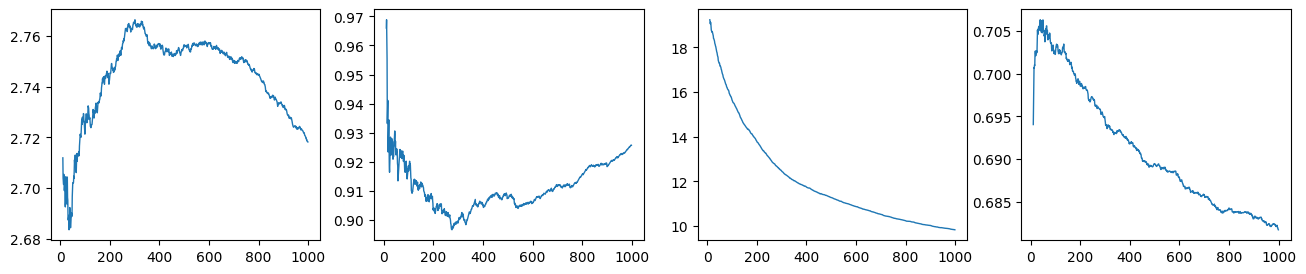

In [ ]:
print(len(losses))
plt.figure(figsize=(16, 3))
for i, s in enumerate([losses, accuracies, losses_mlm, losses_ce]):
    plt.subplot(1, 4, i+1)
    pd.Series(s).ewm(1000).mean()[10:].plot(lw=1);

In [ ]:
plot_for_report(losses, r"Значение функции ошибки $\mathcal{J}_{align}(\phi)$")

# plt.savefig('drive/MyDrive/diploma/loasses2_2k+1k+1k.pdf')
# plt.show()

In [ ]:
plot_for_report(accuracies, r"Точность")

# plt.savefig('drive/MyDrive/diploma/accuracies2_2k+1k+1k.pdf')
# plt.show()

In [ ]:
plot_for_report(losses_mlm, r"Значение функции ошибки $\mathcal{J}_{MLM}(\phi)$")

# plt.savefig('drive/MyDrive/diploma/losses2_MLM_2k+1k+1k.pdf')
# plt.show()